#### MetaData - Prepared manually by taking the Fitness -https://royalsocietypublishing.org/doi/10.1098/rspb.2015.2292 & the allele count data and sequencing data - https://github.com/benjaminhgood/LTEE-metagenomic.

##### import libary

In [1]:
import sys
sys.path.append("../../..")
# sys.path.append("../../../data/")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import linregress
import warnings
import kaos
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('mode.chained_assignment', None)

In [3]:
df_57500_loaded = pd.read_csv("accumulated_gain with 57.5k as reference.csv")
# df_0_loaded = pd.read_csv("accumulated_gain with 0k as reference.csv")
df_wt_loaded = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Gain score")

##### kGain distribution histogram

In [4]:
df_Gain_calculated = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Gain score")
df_Gain_calculated.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914
1,201,thrL,T->G,T,G,missense,p6,-1.750693
2,241,thrL,A->C,A,C,missense,m1,-0.911836
3,309,thrA,T->G,T,G,noncoding,m1,4.009052
4,322,thrA,A->G,A,G,noncoding,p3,1.532477


In [5]:
df_Alt_allele_count_all_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
df_Alt_allele_count_all_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Alt_allele_count_all_generation.reset_index(inplace=True, drop=True)

In [6]:
df_complete = pd.merge(df_Gain_calculated,df_Alt_allele_count_all_generation, on=['Position','Gene','Allele','Annotation','Ref_allele','Alt_allele','label'], how = "left")
df_complete.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain,CHROM,AC:0,...,AC:55500,AC:56000,AC:56500,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914,chrI,0,...,49,78,45,22,36,39.0,11.0,1.0,1.0,6.0
1,201,thrL,T->G,T,G,missense,p6,-1.750693,chrI,0,...,100,140,93,28,79,62.0,15.0,3.0,0.0,13.0
2,241,thrL,A->C,A,C,missense,m1,-0.911836,chrI,0,...,6,1,2,0,0,0.0,0.0,0.0,0.0,0.0
3,309,thrA,T->G,T,G,noncoding,m1,4.009052,chrI,0,...,0,0,0,0,0,0.0,1.0,2.0,7.0,9.0
4,322,thrA,A->G,A,G,noncoding,p3,1.532477,chrI,0,...,23,24,13,16,26,8.0,30.0,22.0,23.0,0.0


In [7]:
filtered_list = [item for item in df_complete if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
filtered_list.extend(['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label', "accumulated_gain"]) ##Add other relavent information
df_allele_generation = df_complete[filtered_list]
df_allele_generation.head() # Get complete dataframe containing all generation wise allele count and other relavent column

,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,...,AC:60000,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0.0,0,0,0,0,0,...,6.0,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0.0,0,0,0,0,0,...,13.0,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0.0,0,0,0,0,0,...,9.0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


In [8]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

In [9]:
nan_columns = df_allele_generation.columns[df_allele_generation.isna().any()]
df_with_nan = df_allele_generation[nan_columns]
nan_counts = df_allele_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


In [10]:
df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
df_allele_generation.reset_index(inplace=True, drop = True)
df_allele_generation.head()

,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57500,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0,0,0,0,0,0,...,36,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0,0,0,0,0,0,...,79,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0,0,0,0,0,0,...,0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0,0,0,0,0,0,...,0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0,0,0,0,0,0,...,26,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


In [11]:
data_all_copy = df_allele_generation.copy()
all_mutation = pd.DataFrame() # The all_mutation dataframe contain generation and population wise accumulated gain

for i in data_all_copy.columns[:-9]:
    new_df_tmp = pd.DataFrame()
    new_df = data_all_copy[data_all_copy.loc[:, i]!=0]
    new_df_tmp = new_df[["label", 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation']]
    new_df_tmp.loc[:, "generation"] = i
    new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulated_gain"]
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
    
all_mutation.reset_index(inplace=True, drop=True)
all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)
for i in range(all_mutation.shape[0]):
    
    if all_mutation.loc[i, "label"] in mutator_list:
        all_mutation.loc[i, "mutator"] = "mutator"
    if all_mutation.loc[i, "label"] in non_mutator_list:
        all_mutation.loc[i, "mutator"] = "non mutator"

all_mutation.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,AG,allele count,generation_number,mutator
0,m6,chrI,1457,thrA,G->A,missense,AC:0,-8.160701,1,0,non mutator
1,m2,chrI,2098,thrA,A->G,missense,AC:0,0.007780,1,0,mutator
2,m2,chrI,2942,thrB,A->G,missense,AC:0,-4.953477,1,0,mutator
3,m4,chrI,5437,yaaX,A->G,missense,AC:0,-10.279634,1,0,mutator
4,m5,chrI,7129,yaaJ,A->C,missense,AC:0,2.182288,2,0,non mutator


In [14]:
# df_0_loaded.rename(columns={"accumulated_gain": "kGain G0"}, inplace=True)
# df_0_loaded

In [15]:
df_57500_loaded.rename(columns={"accumulated_gain": "kGain 57500"}, inplace=True)

In [16]:
df_57500_loaded

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,kGain 57500
0,63,intergenic,A->C,A,C,noncoding,p6,-1.937942
1,201,thrL,T->G,T,G,missense,p6,1.157555
2,241,thrL,A->C,A,C,missense,m1,-0.911836
3,309,thrA,T->G,T,G,noncoding,m1,3.989634
4,322,thrA,A->G,A,G,noncoding,p3,8.106801
...,...,...,...,...,...,...,...,...
36917,4629541,lasT,C->T,C,T,missense,m2,-5.104473
36918,4629573,lasT,T->C,T,C,synonymous,m4,-7.698813
36919,4629600,lasT,A->G,A,G,missense,p3,5.607030
36920,4629600,lasT,A->G,A,G,missense,p6,2.753987


In [17]:
all_mutation["Gene"] = all_mutation["Gene"].str.strip()
all_mutation["Allele"] = all_mutation["Allele"].str.strip()



In [18]:
# combined_wt_0 = pd.merge(all_mutation, df_0_loaded[['Position', 'Gene', 'Allele', 'Ref_allele', 'Alt_allele', 'label']])
combined_wt_0_57500  = pd.merge(all_mutation, df_57500_loaded[['Position', 'Gene', 'Allele', 'Ref_allele', 'Alt_allele', 'label', 'kGain 57500']])

In [ ]:
# combined_wt_0_57500[combined_wt_0_57500["Position"]==63]

##### Obtain statistical value

In [19]:
p_stat_ag, ci_ag = utility.dba_stat(data =combined_wt_0_57500[["generation_number", "kGain 57500"]], group_by_col = "generation_number",target_col_name = "kGain 57500", num_permutations = 10000, random_state = 42)


In [20]:
p_stat_ag, ci_ag 

(9.999000099990002e-05, 0.7677403599528456)

In [21]:
# Group by 'generation_number' and calculate median for each score
generation_medians = combined_wt_0_57500.groupby('generation_number').agg({
    # 'esm_score': 'median',
    'kGain 57500': 'median',    
    # 'alt_evo_score': 'median'
}).reset_index()

generation_medians["kGain 57500"] = generation_medians['kGain 57500'].rolling(window=3, center=True).mean()
# generation_medians["smoothed alt_evo_score"] = generation_medians["alt_evo_score"].rolling(window=3, center=True).mean()
# generation_medians["smoothed esm_score"] = generation_medians["esm_score"].rolling(window=3, center=True).mean()
generation_medians

,generation_number,kGain 57500
0,0,NaN
1,1000,-2.452546
2,1500,-2.185594
3,2000,-2.187567
4,3000,-2.035679
...,...,...
104,55500,-0.281290
105,56000,-0.250435
106,56500,-0.185359
107,57000,0.060954


##### Plot heneration wise median

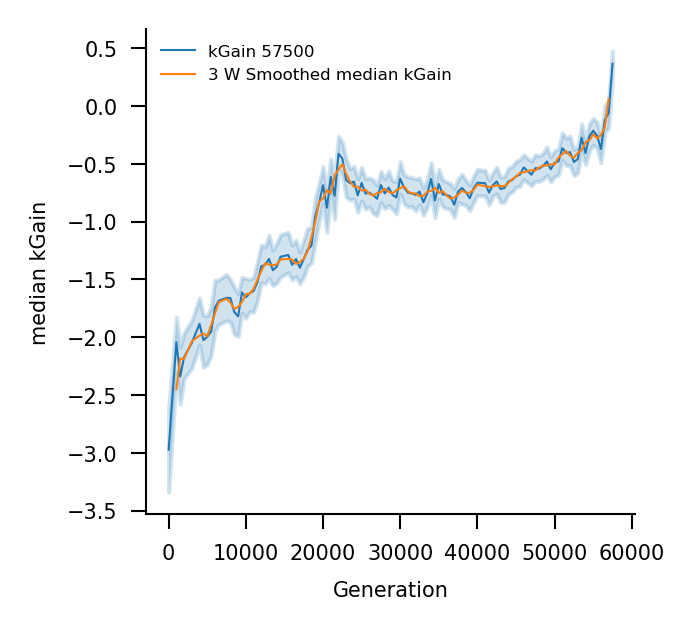

In [22]:
fig, ax = plt.subplots(1, 1, dpi = 300, figsize =(2.1, 2.1))
# ax = sns.lineplot(combined_wt_0_57500, x = "generation_number", y="kGain WT", label = "kgain WT", lw = 0.5, ax=ax, estimator="median")
# ax = sns.lineplot(combined_wt_0_57500, x = "generation_number", y='kGain G0', label = 'kGain G0', lw = 0.5, ax=ax, estimator="median")

ax = sns.lineplot(combined_wt_0_57500, x = "generation_number", y='kGain 57500', label = 'kGain 57500', lw = 0.5, ax=ax, estimator="median")
ax = sns.lineplot(generation_medians, x = "generation_number",  y = "kGain 57500", ax=ax, lw = 0.5, label = "3 W Smoothed median kGain", estimator='median')

# ax = sns.kdeplot(df_0_loaded, x = "accumulated_gain", label = "kgain Gen0", lw = 0.5)
# ax = sns.kdeplot(df_57500_loaded, x = "accumulated_gain", label = "kgain Gen57500", lw = 0.5)
ax.legend(ncol = 1, fontsize = 4, frameon=False)
# ax.set_title("kGain distribution with differet generation as reference", fontsize = 5)
ax.set_ylabel("median kGain")
ax.set_xlabel("Generation")

ax= utility.custom_figure_axis(ax=ax, fontsize = 5, rotation = 0)
# plt.savefig("val hypthesis.pdf", dpi =300)